In [1]:
from tools import audio_io
from tools.framed_audio import FramedAudio
from tools import pitch_optimize

from tools import dataset

from tools import extract_overtones

import numpy as np

from matplotlib import pyplot as plt

import crepe.core

import warnings

from tqdm import tqdm
from scipy import interpolate

Found no cached audio or audio with outdated conig. Will re-run analysis
2560/2560 [==============================] - 18s 7ms/sample
Running optimized pitch extraction, block size=2048, hop size=256


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2201/2201 [05:36<00:00,  6.53it/s]


Done


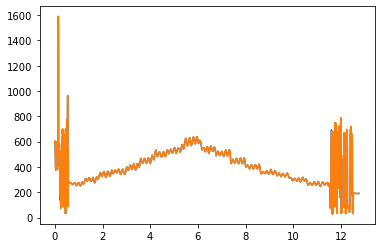

In [2]:
# config
hop_size = 256
block_size = 2048

rerun_analysis = True

config = {
    'centered':True,
    'block-size':block_size,
    'hop-size':hop_size
}

# dataset & audio
vocalset_root = dataset.get_root_path()
src_file = vocalset_root + '/female4/scales/slow_forte/f4_scales_c_slow_forte_o.ogg'

json_tmp = 'build/sample.json'

# init audio object, repeat 
audio = FramedAudio.from_json(json_tmp)
if((audio is None) or (not audio.matches_cfg(config)) or rerun_analysis):

    print('Found no cached audio or audio with outdated conig. Will re-run analysis')

    audio = FramedAudio.from_file(src_file,  config=config)

    # run crepe
    step_size = 5
    crepe_time, crepe_pitch, confiidence, _ = crepe.predict(audio.get_raw(), audio.fs, step_size = step_size, center=True)

    # interpolate results from crepe
    crepe_interpolator = interpolate.interp1d(crepe_time, crepe_pitch)
    time = audio.get_time( centered=True)

    crepe_pitch_interp = crepe_interpolator(time)


    # run min-search pitch estimation
    pitch, pitch_inc = pitch_optimize.pitch_optimize(audio, 
                                                    pitch_estimate = crepe_pitch_interp,
                                                    options = {
                                                    'skip_f0_estimation':False,  
                                                    'method':'Nelder-Mead'},
                                                    num_threads=15)


    audio.store_trajectory('pitch', pitch)
    audio.store_trajectory('pitch-inc', pitch_inc)
    audio.store_trajectory('crepe', crepe_pitch_interp)

else:
    print('Found cached data')

# store data in json
audio.save_json(json_tmp)

# load trajectories
time = audio.get_time()
pitch = audio.get_trajectory('pitch')
pitch_inc = audio.get_trajectory('pitch-inc')
crepe_pitch_interp = audio.get_trajectory('crepe')

fs = audio.fs

# plot some things
plt.plot(time, crepe_pitch_interp, time, pitch)



In [4]:
num_overtones_synthesis = 40

synth1 = np.zeros(audio.get_num_frames() * audio.hop_size + (audio.block_size - audio.hop_size))

print('Start Synthesis')
for i in tqdm(range(int(audio.get_num_frames()))):

    frame = audio.get_frame(i)

    window = np.hanning(audio.block_size)

    frame = frame * window

    _, synth_frame = extract_overtones.extract_ovetones(frame, pitch[i], pitch_inc[i], fs, num_overtones_synthesis)

    synth_frame = synth_frame * 2 * window

    i1 = i * audio.hop_size
    i2 = i1 + audio.block_size
    synth1[i1:i2] += synth_frame * (audio.hop_size / audio.block_size)

  0%|▎                                                                                                                                          | 5/2201 [00:00<00:47, 45.90it/s]

Start Synthesis


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2201/2201 [00:47<00:00, 46.26it/s]


In [5]:

import IPython
IPython.display.Audio(synth1, rate=fs )

In [16]:
num_overtones_synthesis = 40

synth2 = np.zeros(audio.get_num_frames() * audio.hop_size + (audio.block_size - audio.hop_size))

print('Start Synthesis')
for i in tqdm(range(int(audio.get_num_frames()))):

    frame = audio.get_frame(i)

    window = np.hanning(audio.block_size)

    frame = frame * window

    _, synth_frame = extract_overtones.extract_ovetones(frame, crepe_pitch_interp[i], 0, fs, num_overtones_synthesis)

    synth_frame = synth_frame * 2 * window

    i1 = i * audio.hop_size
    i2 = i1 + audio.block_size
    synth2[i1:i2] += synth_frame * (audio.hop_size / audio.block_size)

  0%|▎                                                                                                                                          | 5/2201 [00:00<00:49, 44.26it/s]

Start Synthesis


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2201/2201 [00:51<00:00, 42.39it/s]


In [17]:
import IPython
IPython.display.Audio(synth2, rate=fs )

In [18]:
import IPython
IPython.display.Audio(audio.get_raw(), rate=fs )

<IPython.core.display.Javascript object>


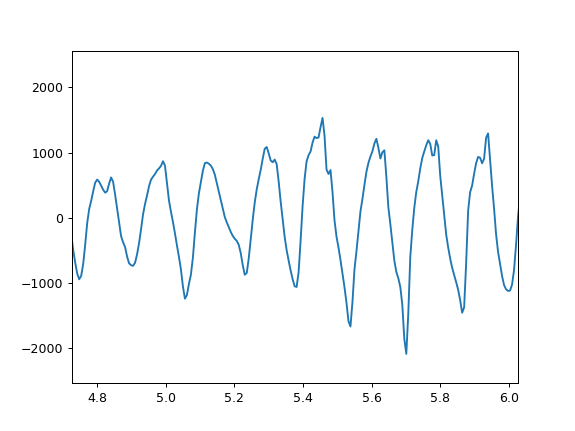

In [3]:
%matplotlib notebook
plt.plot(time, pitch_inc)
plt.show()

In [23]:
plt.plot(time, pitch_inc)